# Checking the Quality of Isobaric Labeling Proteomics Data

Mass spectrometry (MS)-based proteomics has been emerging as a powerful variety of the modern high-throughput *omics* technologies. Superficial search on Pubmed yields [tens of thousands papers](https://pubmed.ncbi.nlm.nih.gov/?term=proteomics%5BTitle%2FAbstract%5D+AND+%28%28mass+spectrometry%5BTitle%2FAbstract%5D%29+OR+%28LCMS%5BTitle%2FAbstract%5D%29%29+OR+%28LC-MS%5BTitle%2FAbstract%5D%29) where the MS-based proteomics is mentioned in the title or abstract, let alone the papers where in which is a humble workhorse hidden deep in the Methods section.<br>
[Isobaric labeling-based proteomics](https://en.wikipedia.org/wiki/Isobaric_labeling#:~:text=Isobaric%20labeling%20is%20a%20mass,heavy%20isotopes%20around%20their%20structure.), including [Tandem mass tags (TMT)](https://pubs.acs.org/doi/10.1021/ac0262560) technology, is an approach for multiplexed relative protein quantification that is based on chemical labeling of peptides with the set of the stable isotope-substituted reagents. For a given peptide, all reagents would yield the same total mass, but the signals with distinct masses (reporter ions) would be produced upon fragmentation during a tandem MS experiment. In 2021, the commercially available technology is offering to measure up to 16 samples simultaneously (for more technical information, see [the manual at the vendor's website](https://www.thermofisher.com/document-connect/document-connect.html?url=https%3A%2F%2Fassets.thermofisher.com%2FTFS-Assets%2FLSG%2Fmanuals%2FMAN0018773_TMTproMassTagLabelingReagentsandKits_UG.pdf&title=VXNlciBHdWlkZTogVE1UcHJvIE1hc3MgVGFnIExhYmVsaW5nIFJlYWdlbnRzIGFuZCBLaXRz)).
Isobaric proteomic data is complex: proteolytic peptides should be identified, the reporter ions must be quantified, the quantification data should be normalized, peptide-level data should be assembled into the protein quantification results. There are plenty of things that may go wrong, thus the thorough inspection of the quality of the acquired isobaric labeling data. This notebook includes the range of command that help me out with checking the quality of the data. I will not go into the biological interpretation or anything like that, this is the inspection from the technical standpoint for the most part. The commands are adapted to the text output format provided by Proteome Discovere 2.4, but they can be adapted to the output from other data processing solutions.

<h2>Import the libraries</h2>

Install the dependencies below via *pip* *install* *package-name* if you do not yet have them on your machine.

In [1]:
import os, glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

sns.set(font_scale = 1.2)
sns.set_style('whitegrid')
sns.set_palette('muted')

We could also go ahead and define a few useful functions that we're going to use along the way.

In [2]:
def get_gene_name(descr):
    try:
        gn = descr.split('GN=')[1]
        gn = gn.split(' ')[0]
    except:
        gn = ''
    return gn

def variability_groupby(df, ratio_columns, accession_col='Accession',
                          use_peptides='all',shared_keyword='Shared', unique_infocol='Quan Info'):
    if use_peptides == 'unique':
        df = df[~df[unique_infocol].isin((shared_keyword,))].copy()
    elif use_peptides == 'all':
        pass
    else:
        df = None
        
    dfN = df[ ([accession_col,] + ratio_columns) ]
    
    dfMeans = dfN.groupby([accession_col]).mean()
    dfDev = dfN.groupby([accession_col]).std()
    dfVar = np.divide(dfDev, dfMeans)
    dfVar = dfVar*100
    dfVar.replace(0, np.nan, inplace=True)
    dfVar = dfVar.round(2)
    
    return dfVar

def pca_on_columns(in_df, plotname, nComp=5, compToPlot=(0,1), figWidth = 8 ):
    """
    Takes an expression table, with samples as columns and proteins in rows.
    Figure width is set by the user,
    figure height is derived automatically based on the scale of the PCs. 
    """
    
    samplenames = list(in_df.columns)
    logdata = in_df.to_numpy()

    X = logdata.transpose()

    pca = PCA(n_components=nComp, svd_solver='arpack')
    principalComponents = pca.fit_transform(X)
    
    print('Variance explained by components:')
    print(pca.explained_variance_ratio_)
    
    pcaLoadings = pd.DataFrame(pca.components_.T,
                               columns=[ f'PC{n+1}' for n in range(nComp) ],
                               index=in_df.index)
    
    pcColnames = []
    for n in range(nComp):
        pcColnames.append( f'PC {n+1} ({pca.explained_variance_ratio_[n]*100:.2f}%)' )

    principalDf = pd.DataFrame(principalComponents,
                               columns = pcColnames)
    principalDf['sample'] = samplenames
    principalDf.set_index('sample', inplace = True)
    
    #Find min and max values on x and y axes in order to detrmine the figsize
    arrX = principalDf[ pcColnames[ compToPlot[0] ] ]
    arrY = principalDf[ pcColnames[ compToPlot[1] ] ]
    spanX = max(arrX) - min(arrX)
    spanY = max(arrY) - min(arrY)
    plotH = round(figWidth * spanY / spanX, 1)
    print(f'Figure width set to {figWidth} and height to {plotH}')
    
    f = plt.figure()
    f.patch.set_facecolor('white')
    ax1 = principalDf.plot.scatter(x=pcColnames[ compToPlot[0] ],
                                   y=pcColnames[ compToPlot[1] ],
                                   color='#213A8F',
                                   s=50, alpha=0.7, figsize=(figWidth, plotH) )
    ax1.axhline(color='grey', alpha=0.4, linestyle='--')
    ax1.axvline(color='grey', alpha=0.4, linestyle='--')
    
    for i, row in principalDf.iloc[:, list(compToPlot) ].iterrows():
        ax1.annotate(i, row,
                     xytext=(10,-5), textcoords='offset points',
                     fontsize=12, color='#213A8F')
    ax1.set_title(plotname, fontsize=16)
    plt.grid(b=None)
    
    #plt.show()

    return principalDf, pcaLoadings

def rename_ratios(dfIn):
    """
    Used for the file QuanSpectra
    """
    renaming_dict = {}
    for c in dfIn.columns:
        if 'Abundances Normalized' in c:
            new_name = c.split(' ')[-1]
            new_name = 'Norm_' + new_name
            renaming_dict[c] = new_name
        elif 'Abundance ' in c:
            new_name = c.split(' ')[-1]
            renaming_dict[c] = new_name
    dfOut = dfIn.rename(renaming_dict,axis='columns')
    return dfOut

def rename_ratios4(dfIn):
    """
    Adapted for Peptide Groups table
    """
    renaming_dict = {}
    for c in dfIn.columns:
        if 'Abundance Ratio' in c:
            new_name = c.split(' ')[-3] + '/' + c.split(' ')[-1]
            renaming_dict[c] = new_name
        elif 'Abundances Grouped' in c:
            new_name = c.split(' ')[-1]
            renaming_dict[c] = new_name
        renaming_dict['Master Protein Accessions'] = 'Accession'
    dfOut = dfIn.rename(renaming_dict,axis='columns')
    return dfOut

<h2>Take a look at the output files from Proteome Discoverer</h2>

The LC-MS files that I will use for demonstration are publicly available via PRIDE repository with [identifier PXD007647](https://www.ebi.ac.uk/pride/archive/projects/PXD007647). This proteomic analysis was a part of [the study published by Thulin and Andersson](https://journals.asm.org/doi/full/10.1128/AAC.00612-19) in the journal Antimicrobial Agents and Chemotherapy. The particular batch that we will be looking at consists of 10 <i>E. coli</i> samples, labeled with TMT tags and pre-fractionated into 

To make our lives easier, I have added the *Results Exporter* node to the consensus workflow in Proteome Discovere 2.4, so that we get a bunch of .TXT output files right in the study directory when the processing is finished. There are not many options in that node, I have marked an option "R-friendly headers" as TRUE.

The output files are in the sub-directory "PD_Out"

In [3]:
proteomicTxtFiles = [
    os.path.join('/PD_Out', f) for f in os.listdir(os.getcwd() + '/PD_Out') if f.endswith('.txt')
]
for f in proteomicTxtFiles:
    print(f)

/PD_Out/PXD007647_Reproc_TMT-set-2_8fracs_QuanSpectra.txt
/PD_Out/PXD007647_Reproc_TMT-set-2_8fracs_SpecializedTraces.txt
/PD_Out/PXD007647_Reproc_TMT-set-2_8fracs_Proteins.txt
/PD_Out/PXD007647_Reproc_TMT-set-2_8fracs_PeptideGroups.txt
/PD_Out/PXD007647_Reproc_TMT-set-2_8fracs_MSMSSpectrumInfo.txt
/PD_Out/PXD007647_Reproc_TMT-set-2_8fracs_PSMs.txt
/PD_Out/PXD007647_Reproc_TMT-set-2_8fracs_ResultStatistics.txt
/PD_Out/PXD007647_Reproc_TMT-set-2_8fracs_ProteinGroups.txt
/PD_Out/PXD007647_Reproc_TMT-set-2_8fracs_InputFiles.txt
/PD_Out/PXD007647_Reproc_TMT-set-2_8fracs_PrSMs.txt


For convenience, assign the name or a project number to the data set.

In [11]:
PNUM = 'Ecoli TMT'

<h2>Get on the files one-by-one</h2>

<h3>File InputFiles</h3>

In [8]:
df1 = pd.read_csv(
    os.getcwd() + [ n for n in proteomicTxtFiles if 'InputFiles' in n ][0],
    sep='\t'
)
df1['count'] = [1,] * df1.index
print(df1.shape)
print(df1.columns)
df1.head(3)

(9, 10)
Index(['Input Files Workflow ID', 'Input Files Workflow Level', 'Input Files ',
       'Study File ID', 'File Name', 'Creation Date', 'RT Range in min',
       'Instrument Name', 'Software Revision', 'count'],
      dtype='object')


,Input Files Workflow ID,Input Files Workflow Level,Input Files,Study File ID,File Name,Creation Date,RT Range in min,Instrument Name,Software Revision,count
0,5225,0,12455,NaN,C:\Data\PXD007647_Reproc\PD24\PXD007647_Reproc...,6/30/2021 1:54:35 PM,NaN,NaN,Created with Discoverer version: 2.4.0.305,0
1,-107,1,12447,F1.1,C:\Data\PXD007647_Reproc\RAW\Fusion_170530_91.raw,6/2/2017 9:53:00 PM,0.00 - 90.00,Orbitrap Fusion,2.1.1565.23,1
2,-107,1,12448,F1.2,C:\Data\PXD007647_Reproc\RAW\Fusion_170530_92.raw,6/2/2017 11:38:09 PM,0.00 - 90.00,Orbitrap Fusion,2.1.1565.23,2


The first file is a Proteome Discoverer .MSF file that stores the intermediate processing results:

In [9]:
df1['File Name'][0]

'C:\\Data\\PXD007647_Reproc\\PD24\\PXD007647_Reproc\\PXD007647_Reproc_TMT-set-2_8fracs.msf'

The rest of the files are the LC-MS .RAW files, there are eight:

In [10]:
df1['File Name'][1:]

1    C:\Data\PXD007647_Reproc\RAW\Fusion_170530_91.raw
2    C:\Data\PXD007647_Reproc\RAW\Fusion_170530_92.raw
3    C:\Data\PXD007647_Reproc\RAW\Fusion_170530_93.raw
4    C:\Data\PXD007647_Reproc\RAW\Fusion_170530_94.raw
5    C:\Data\PXD007647_Reproc\RAW\Fusion_170530_95.raw
6    C:\Data\PXD007647_Reproc\RAW\Fusion_170530_96.raw
7    C:\Data\PXD007647_Reproc\RAW\Fusion_170530_97.raw
8    C:\Data\PXD007647_Reproc\RAW\Fusion_170530_98.raw
Name: File Name, dtype: object

What useful info can we find in the InputFiles table?

In [11]:
list(df1['Study File ID'])

[nan, 'F1.1', 'F1.2', 'F1.3', 'F1.4', 'F1.5', 'F1.6', 'F1.7', 'F1.8']

File IDs follow a pattern F1.x. In Proteome Discoverer, it suggests that we have **one** TMT labeling set, and all eight files are the **fractions** that all belong to the same TMT set. Eight LC-MS files are essentially treated as one big file during data analysis

In [12]:
df1['Software Revision'].unique()

array(['Created with Discoverer version: 2.4.0.305', '2.1.1565.23'],
      dtype=object)

These are the versions of Proteome Discoverer (the former) and of the Orbitrap Tune software on the computer that acquired the data (the latter).

In [13]:
df1['Instrument Name'].unique()

array([nan, 'Orbitrap Fusion'], dtype=object)

The first generation Orbitrap Fusion acquired the LC-MS files

In [14]:
df1['RT Range in min'].unique()

array([nan, '0.00 - 90.00', '0.00 - 90.01'], dtype=object)

We could determine the LC-MS file length in minutes, it will be handy for plotting down the line.

In [15]:
rtRangeMaxVals = [
    float( x.split(' - ')[-1] ) for x in df1['RT Range in min'].unique() if type(x) == str
]
rtRangeMaxVals

[90.0, 90.01]

In [16]:
maxRT = int( max(rtRangeMaxVals) )
maxRT

90

<h3>File MSMSSpectrumInfo</h3>

In [17]:
df2 = pd.read_csv(
    os.getcwd() + [ n for n in proteomicTxtFiles if 'MSMSSpectrumInfo' in n ][0],
    sep='\t'
)
df2['count'] = [1,] * df2.index
print(df2.shape)
print(df2.columns)
df2.head(3)

(172414, 20)
Index(['MSMS Spectrum Info Workflow ID', 'MSMS Spectrum Info Spectrum ID',
       'Checked', 'File ID', 'RT in min', 'First Scan', 'Mass Analyzer',
       'Activation Type', 'MS Order', 'Number of PSMs',
       'Number of Peptide Groups', 'Isolation Interference in Percent',
       'Ion Inject Time in ms', 'Number of Precursors',
       'Number of Identified Precursors', 'Precursor mz in Da',
       'Precursor MHplus in Da', 'Precursor Charge', 'Spectrum File', 'count'],
      dtype='object')


,MSMS Spectrum Info Workflow ID,MSMS Spectrum Info Spectrum ID,Checked,File ID,RT in min,First Scan,Mass Analyzer,Activation Type,MS Order,Number of PSMs,Number of Peptide Groups,Isolation Interference in Percent,Ion Inject Time in ms,Number of Precursors,Number of Identified Precursors,Precursor mz in Da,Precursor MHplus in Da,Precursor Charge,Spectrum File,count
0,-107,1,False,F1.1,0.0113,3,IonTrap,CID,MS2,0,0,0.00000,50.0,1,0,573.83301,1146.65874,2,Fusion_170530_91.raw,0
1,-107,2,False,F1.1,0.2745,35,IonTrap,CID,MS2,0,0,0.00000,50.0,1,0,817.21338,1633.41948,2,Fusion_170530_91.raw,1
2,-107,3,False,F1.1,0.9930,119,IonTrap,CID,MS2,0,0,21.72546,50.0,1,0,421.83243,842.65758,2,Fusion_170530_91.raw,2


For an ease of plotting, let's add a categorical column "Identified Peptide" that have two strings as values: "Yes" or "No"

In [18]:
yes_or_no = lambda x: 'NoID' if x==0 else 'WithID'
df2['Identified Peptide'] = [
    yes_or_no( row['Number of PSMs'] ) for _,row in df2.iterrows()
]
df2.head(3)

,MSMS Spectrum Info Workflow ID,MSMS Spectrum Info Spectrum ID,Checked,File ID,RT in min,First Scan,Mass Analyzer,Activation Type,MS Order,Number of PSMs,...,Isolation Interference in Percent,Ion Inject Time in ms,Number of Precursors,Number of Identified Precursors,Precursor mz in Da,Precursor MHplus in Da,Precursor Charge,Spectrum File,count,Identified Peptide
0,-107,1,False,F1.1,0.0113,3,IonTrap,CID,MS2,0,...,0.00000,50.0,1,0,573.83301,1146.65874,2,Fusion_170530_91.raw,0,NoID
1,-107,2,False,F1.1,0.2745,35,IonTrap,CID,MS2,0,...,0.00000,50.0,1,0,817.21338,1633.41948,2,Fusion_170530_91.raw,1,NoID
2,-107,3,False,F1.1,0.9930,119,IonTrap,CID,MS2,0,...,21.72546,50.0,1,0,421.83243,842.65758,2,Fusion_170530_91.raw,2,NoID


In [19]:
print(df2['Mass Analyzer'].unique())
print(df2['Activation Type'].unique())

['IonTrap']
['CID']


The MSMS spectra were acquired with the ion trap analyzer with CID activation.

Let's look at the success rate of peptide identification. A very low number of PSMs per MSMS may signal problems with the sample prep, acquisition or database search.

Text(0.5, 0.98, 'Ecoli TMT PSMs per MSMS')

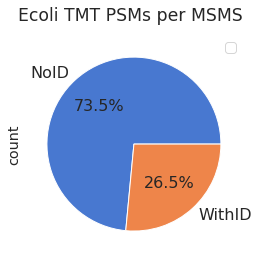

In [21]:
fig1, ax1 = plt.subplots()
df2[
    ['Identified Peptide', 'count']
].groupby(
    ['Identified Peptide']
).count().plot(
    kind = 'pie', ax = ax1,
    y = 'count', figsize = (4,4),
    autopct = '%1.1f%%', fontsize = 16
)
fig1.set_facecolor("white")
plt.legend('')
plt.suptitle(f'{PNUM} PSMs per MSMS')

Text(0, 0.5, '')

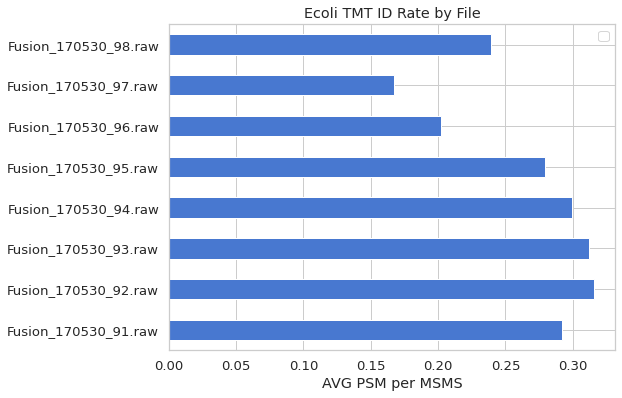

In [22]:
df2[
    ['Spectrum File', 'Number of PSMs']
].groupby(
    ['Spectrum File']
).mean().plot.barh(figsize=(8,6))
plt.title(f'{PNUM} ID Rate by File')
plt.legend('')
plt.xlabel('AVG PSM per MSMS')
plt.ylabel('')

The ID rate varies between the .RAW files, which can be useful for the optimization of the pre-fractionation method. We can also spot if there was something wrong with one or more of the files.

Text(0.5, 0.98, 'Ecoli TMT All MSMS Spectra Per Min Per File / Retention time on x-axis')

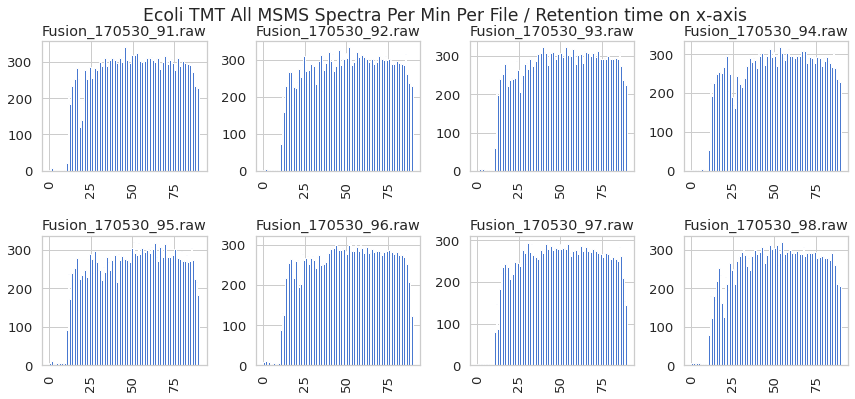

In [23]:
df2[
    ['Spectrum File', 'RT in min']
].hist(
    by='Spectrum File', bins=maxRT, layout=(2,4), figsize=(14,6)
)
plt.suptitle(f'{PNUM} All MSMS Spectra Per Min Per File / Retention time on x-axis')

These plots show the distribution of all the MSMS spectra over the elution profile. The spectra are acquired rather uniformly over the LC gradient.

Text(0.5, 0.98, 'Ecoli TMT Spectra With ID Per Min Per File / Retention time on x-axis')

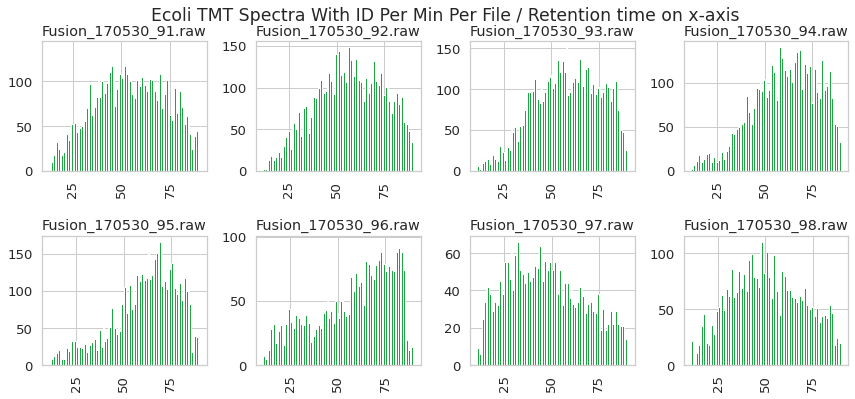

In [24]:
df2[
    df2['Number of PSMs'] > 0
][
    ['Spectrum File', 'RT in min']
].hist(
    by='Spectrum File', bins=maxRT, layout=(2,4), figsize=(14,6),
    color = '#1ca641'
)
plt.suptitle(f'{PNUM} Spectra With ID Per Min Per File / Retention time on x-axis')

Text(0.5, 0.98, 'Ecoli TMT')

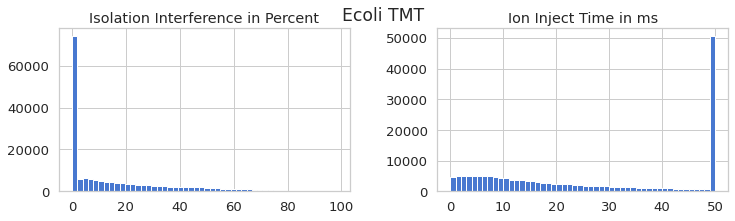

In [25]:
df2[
    ['Isolation Interference in Percent', 'Ion Inject Time in ms']
].hist( bins=50, figsize=(12,3) )
plt.suptitle(f'{PNUM}')

Isolation interference is the percentage of the ion intensity in the isolation window that does not belong to the "main" precursor in that window.<br>Low values mean less probability of co-isolation of two or more peptides that leads to complicated mixture fragmentation spectra.<br>
Knowing the distribution of the injection times may be useful for tuning the MS method.

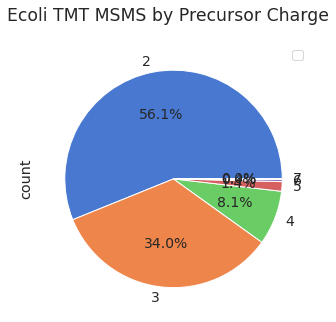

In [26]:
fig1, ax1 = plt.subplots()
df2[
    ['Precursor Charge', 'count']
].groupby(
    ['Precursor Charge']
).count().plot(
    kind='pie', ax=ax1,
    y='count', figsize=(6,5),
    autopct='%1.1f%%', fontsize=14
)
fig1.set_facecolor("white")
plt.suptitle(f'{PNUM} MSMS by Precursor Charge')
plt.legend('')

The distribution of all the MSMS spectra by charge. The 2+ precursors are prevalent.

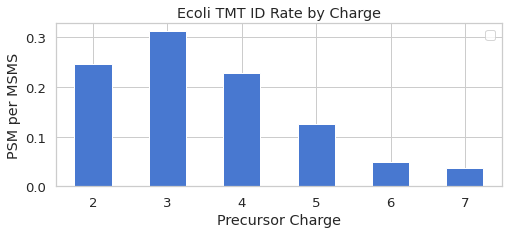

In [27]:
df2[
    ['Precursor Charge', 'Number of PSMs']
].groupby(
    ['Precursor Charge']
).mean().plot.bar(figsize=(8,3), rot=0)
plt.title(f'{PNUM} ID Rate by Charge')
plt.ylabel('PSM per MSMS')
plt.legend('')

Text(0.5, 0, 'Precursor MH+ (Da)')

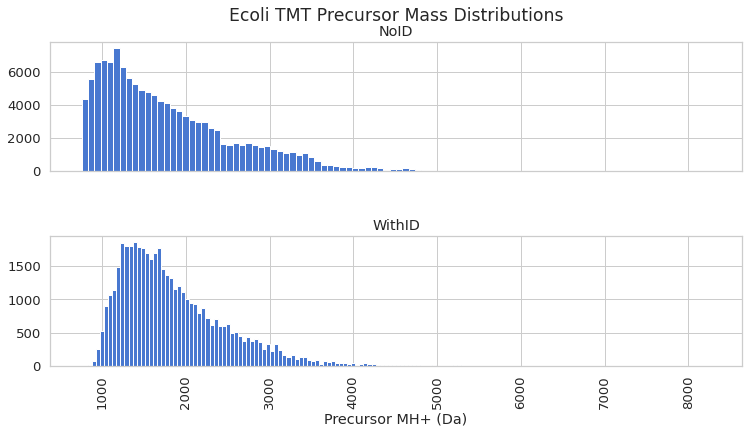

In [28]:
df2[
    ['Identified Peptide', 'Precursor MHplus in Da']
].hist(
    by='Identified Peptide', bins=100, sharex=True, sharey=False,
    layout=(2,1), figsize=(12,6)
)
plt.suptitle(f'{PNUM} Precursor Mass Distributions')
plt.xlabel('Precursor MH+ (Da)')

Text(0.5, 0, 'Precursor m/z')

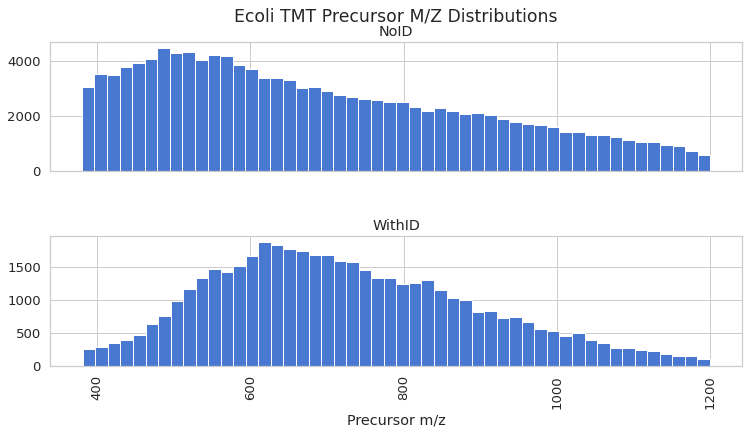

In [29]:
df2[
    ['Identified Peptide', 'Precursor mz in Da']
].hist(
    by='Identified Peptide', bins=50, sharex=True, sharey=False,
    layout=(2,1), figsize=(12,6)
)
plt.suptitle(f'{PNUM} Precursor M/Z Distributions')
plt.xlabel('Precursor m/z')

Same deal with the m/z of the spectra that lead to peptide identifications

We could segment our table by m/z, let's say, at 100 m/z intervals, and look at ID rates in each segment

In [30]:
minMZ = df2[['Precursor mz in Da']].min()
print( f'Min {minMZ}' )
maxMZ = df2[['Precursor mz in Da']].max()
print( f'Max {maxMZ}' )

Min Precursor mz in Da    380.00339
dtype: float64
Max Precursor mz in Da    1199.97229
dtype: float64


Let's split it into intervals of 100, this will help to determine which precursor regions are the most effective in terms of peptide identification.

In [31]:
min100 = int( np.floor(minMZ / 100) )
max100 = int( np.ceil(maxMZ / 100) )

#Generate the dictionary with m/z tuple and corresponding label
intervals = []
for i in range(min100, max100):
    intervals.append( [ 100*i, (i+1)*100 ] )
#Pad the string with zeros for better sorting on subsequent plots
intervals = {
    (x1, x2): f'{x1:04}-{x2:04}' for x1, x2 in intervals
}

def split_mz(mz, intervals):
    intervalString = ''
    for k in intervals.keys():
        if (mz > k[0]) and (mz <= k[1]):
            intervalString = intervals[k]
    return intervalString

df2['MZ interval'] = [
    split_mz( row['Precursor mz in Da'], intervals ) for _,row in df2.iterrows()
]
df2.head(3)

,MSMS Spectrum Info Workflow ID,MSMS Spectrum Info Spectrum ID,Checked,File ID,RT in min,First Scan,Mass Analyzer,Activation Type,MS Order,Number of PSMs,...,Ion Inject Time in ms,Number of Precursors,Number of Identified Precursors,Precursor mz in Da,Precursor MHplus in Da,Precursor Charge,Spectrum File,count,Identified Peptide,MZ interval
0,-107,1,False,F1.1,0.0113,3,IonTrap,CID,MS2,0,...,50.0,1,0,573.83301,1146.65874,2,Fusion_170530_91.raw,0,NoID,0500-0600
1,-107,2,False,F1.1,0.2745,35,IonTrap,CID,MS2,0,...,50.0,1,0,817.21338,1633.41948,2,Fusion_170530_91.raw,1,NoID,0800-0900
2,-107,3,False,F1.1,0.9930,119,IonTrap,CID,MS2,0,...,50.0,1,0,421.83243,842.65758,2,Fusion_170530_91.raw,2,NoID,0400-0500


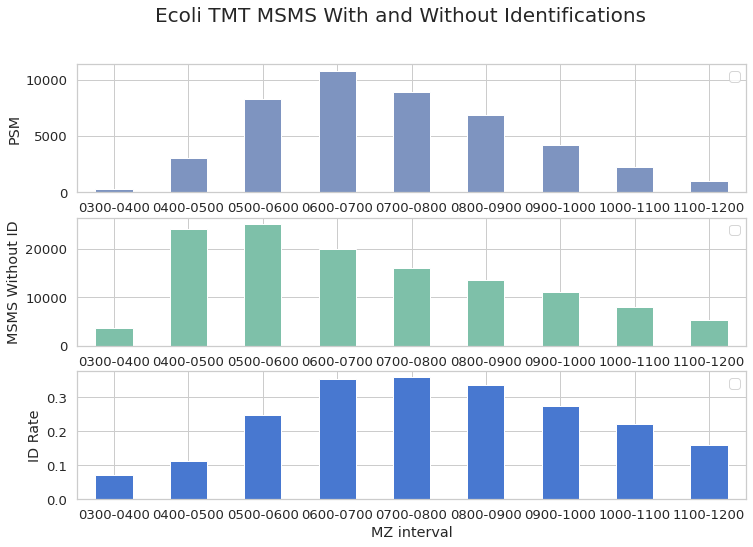

In [32]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=1, nrows=3, figsize=(12, 8))
#PSMs per interval
df2[
    ['Number of PSMs', 'MZ interval']
].groupby(
    ['MZ interval']
).sum().plot.bar(ax=ax1, rot=0, color = '#7E94C0')
ax1.set_ylabel('PSM')
#MSMS without ID per interval
df2[
    df2['Number of PSMs'] == 0
][
    ['Number of PSMs', 'MZ interval']
].groupby(
    ['MZ interval']
).count().plot.bar(ax=ax2, rot=0, color = '#7EC0A9')
ax2.set_ylabel('MSMS Without ID')
#ID rate per interval
df2[
    ['Number of PSMs', 'MZ interval']
].groupby(
    ['MZ interval']
).mean().plot.bar(ax=ax3, rot=0)
ax3.set_ylabel('ID Rate')

plt.suptitle(f'{PNUM} MSMS With and Without Identifications', fontsize = 20)
ax1.legend('')
ax2.legend('')
ax3.legend('')

Let's get a more nuanced picture the picture a bit and add the charges to the mixture.<br>
This can be informative for the optimization of precursor selection settings.

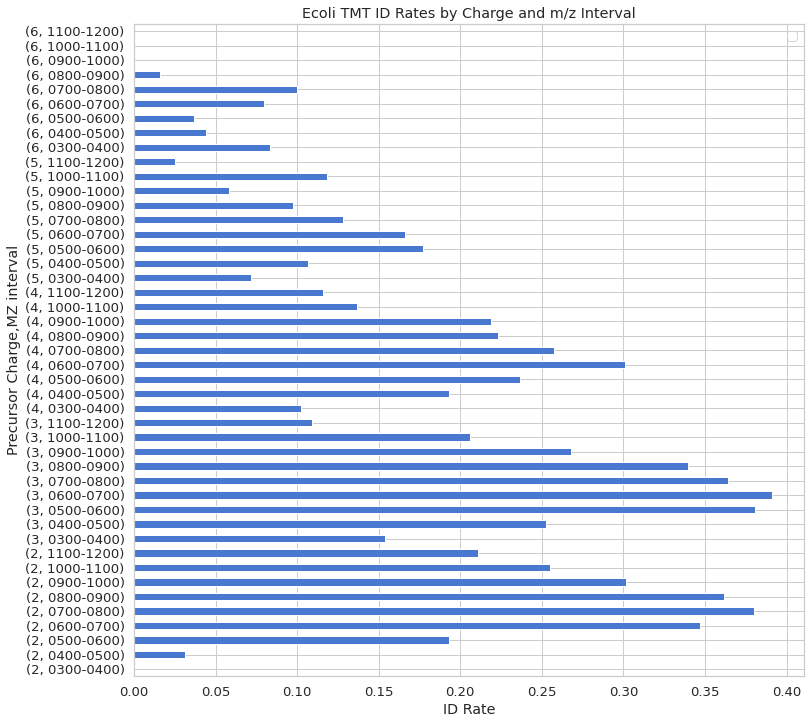

In [33]:
df2[
    df2['Precursor Charge'] <= 6
][
    ['Precursor Charge','Number of PSMs', 'MZ interval']
].groupby(
    ['Precursor Charge', 'MZ interval']
).mean().plot.barh(figsize=(12,12))
plt.title(f'{PNUM} ID Rates by Charge and m/z Interval')
plt.xlabel('ID Rate')
plt.legend('')

<h3>File QuanSpectra</h3>

In [34]:
df3 = pd.read_csv(
    os.getcwd() + [ n for n in proteomicTxtFiles if 'QuanSpectra' in n ][0],
    sep='\t'
)
print(df3.shape)
print(df3.columns)
df3.head(3)

(172532, 38)
Index(['Quan Spectra Workflow ID', 'Quan Spectra Spectrum ID', 'Checked',
       'File ID', 'RT in min', 'First Scan', 'Mass Analyzer',
       'Activation Type', 'MS Order', 'Number of PSMs',
       'Isolation Interference in Percent', 'Average Reporter SN',
       'Ion Inject Time in ms', 'Precursor mz in Da', 'Precursor MHplus in Da',
       'Precursor Charge', 'Spectrum File', 'Abundances Normalized 126',
       'Abundances Normalized 127N', 'Abundances Normalized 127C',
       'Abundances Normalized 128N', 'Abundances Normalized 128C',
       'Abundances Normalized 129N', 'Abundances Normalized 129C',
       'Abundances Normalized 130N', 'Abundances Normalized 130C',
       'Abundances Normalized 131', 'Abundance 126', 'Abundance 127N',
       'Abundance 127C', 'Abundance 128N', 'Abundance 128C', 'Abundance 129N',
       'Abundance 129C', 'Abundance 130N', 'Abundance 130C', 'Abundance 131',
       'Quan Info'],
      dtype='object')


,Quan Spectra Workflow ID,Quan Spectra Spectrum ID,Checked,File ID,RT in min,First Scan,Mass Analyzer,Activation Type,MS Order,Number of PSMs,...,Abundance 127N,Abundance 127C,Abundance 128N,Abundance 128C,Abundance 129N,Abundance 129C,Abundance 130N,Abundance 130C,Abundance 131,Quan Info
0,-107,172534,False,F1.1,0.0132,4,FourierTransform,HCD,MS3,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NoQuanValues
1,-107,172535,False,F1.1,0.2764,36,FourierTransform,HCD,MS3,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NoQuanValues
2,-107,172536,False,F1.1,0.9948,120,FourierTransform,HCD,MS3,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NoQuanValues


In [35]:
df3 = rename_ratios(df3)
#Use the lambda function yes_or_no that we have introduced earlier
df3['Identified Peptide'] = [ yes_or_no( row['Number of PSMs'] ) for _,row in df3.iterrows() ]
df3['Sqrt AVG Reporter SN'] = np.sqrt( df3['Average Reporter SN'] )
df3['Log10 AVG Reporter SN'] = np.log10( df3['Average Reporter SN'].replace(0, np.nan) )
print( [ (i, c) for i, c in enumerate(df3.columns) ] )
df3.head(3)

[(0, 'Quan Spectra Workflow ID'), (1, 'Quan Spectra Spectrum ID'), (2, 'Checked'), (3, 'File ID'), (4, 'RT in min'), (5, 'First Scan'), (6, 'Mass Analyzer'), (7, 'Activation Type'), (8, 'MS Order'), (9, 'Number of PSMs'), (10, 'Isolation Interference in Percent'), (11, 'Average Reporter SN'), (12, 'Ion Inject Time in ms'), (13, 'Precursor mz in Da'), (14, 'Precursor MHplus in Da'), (15, 'Precursor Charge'), (16, 'Spectrum File'), (17, 'Norm_126'), (18, 'Norm_127N'), (19, 'Norm_127C'), (20, 'Norm_128N'), (21, 'Norm_128C'), (22, 'Norm_129N'), (23, 'Norm_129C'), (24, 'Norm_130N'), (25, 'Norm_130C'), (26, 'Norm_131'), (27, '126'), (28, '127N'), (29, '127C'), (30, '128N'), (31, '128C'), (32, '129N'), (33, '129C'), (34, '130N'), (35, '130C'), (36, '131'), (37, 'Quan Info'), (38, 'Identified Peptide'), (39, 'Sqrt AVG Reporter SN'), (40, 'Log10 AVG Reporter SN')]


,Quan Spectra Workflow ID,Quan Spectra Spectrum ID,Checked,File ID,RT in min,First Scan,Mass Analyzer,Activation Type,MS Order,Number of PSMs,...,128C,129N,129C,130N,130C,131,Quan Info,Identified Peptide,Sqrt AVG Reporter SN,Log10 AVG Reporter SN
0,-107,172534,False,F1.1,0.0132,4,FourierTransform,HCD,MS3,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NoQuanValues,NoID,0.0,NaN
1,-107,172535,False,F1.1,0.2764,36,FourierTransform,HCD,MS3,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NoQuanValues,NoID,0.0,NaN
2,-107,172536,False,F1.1,0.9948,120,FourierTransform,HCD,MS3,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NoQuanValues,NoID,0.0,NaN


In [36]:
df3['File ID'].unique()

array(['F1.1', 'F1.2', 'F1.3', 'F1.4', 'F1.5', 'F1.6', 'F1.7', 'F1.8'],
      dtype=object)

Select the columns with normalized abundance

In [37]:
df3.iloc[:,17:27].replace(0, np.nan).dropna(axis='rows').head(3)

,Norm_126,Norm_127N,Norm_127C,Norm_128N,Norm_128C,Norm_129N,Norm_129C,Norm_130N,Norm_130C,Norm_131
81,159.0,142.4,127.0,152.5,111.4,109.7,89.3,119.9,118.1,172.9
107,12.7,10.7,7.5,11.5,4.9,13.7,10.9,8.5,11.1,11.6
113,5.2,6.7,3.7,3.4,4.1,5.6,3.6,3.5,3.8,12.6


Select the columns with non-normalized abundance

In [38]:
df3.iloc[:,27:37].replace(0, np.nan).dropna(axis='rows').head(3)

,126,127N,127C,128N,128C,129N,129C,130N,130C,131
81,120.0,124.9,114.0,140.8,94.0,75.1,71.9,119.9,78.6,124.7
107,9.6,9.4,6.7,10.6,4.1,9.4,8.8,8.5,7.4,8.4
113,3.9,5.9,3.3,3.1,3.5,3.8,2.9,3.5,2.5,9.1


Text(0.5, 0.98, 'Ecoli TMT Set Reporter SN Before and After Normalization')

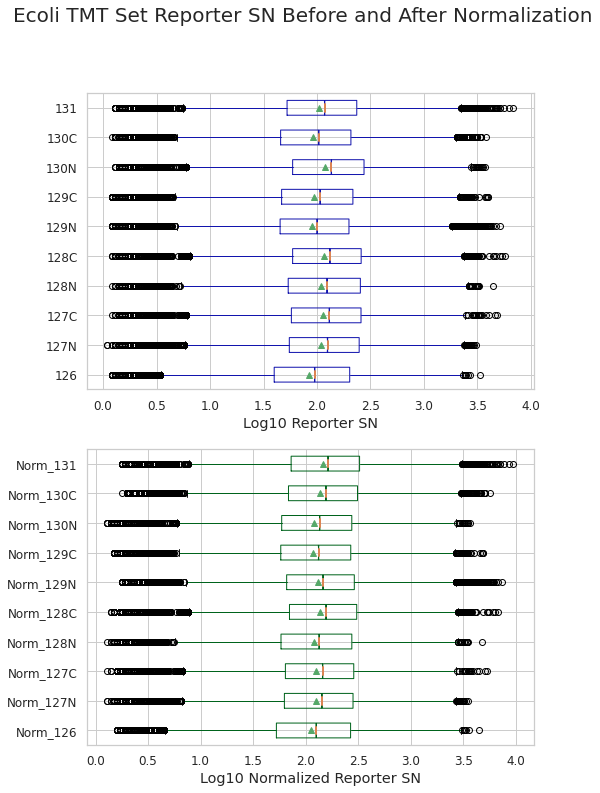

In [39]:
sns.set(font_scale = 1.2)
sns.set_style('whitegrid')

fig, (ax1, ax2) = plt.subplots(ncols=1, nrows=2, figsize=(8, 12))

np.log10(
    df3.iloc[
        :, 27:37
    ].replace(0, np.nan).dropna(axis='rows')
).boxplot(
    ax=ax1, notch=True, showmeans=True,
    vert=False,
    boxprops= dict(linewidth=1, color='#1214AD'),
    whiskerprops= dict(color='#1214AD'),
    medianprops= dict(linewidth=2), fontsize=12
)
ax1.set_xlabel('Log10 Reporter SN')
ax2.set_ylabel('')
#Add the box plot after normalization
np.log10(
    df3.iloc[
        :, 17:27
    ].replace(0, np.nan).dropna(axis='rows')
).boxplot(
    ax=ax2, notch=True, showmeans=True,
    vert=False,
    boxprops= dict(linewidth=1, color='#00631C'),
    whiskerprops= dict(color='#00631C'),
    medianprops= dict(linewidth=2), fontsize=12
)
ax2.set_xlabel('Log10 Normalized Reporter SN')
ax2.set_ylabel('')

plt.suptitle(f'{PNUM} Set Reporter SN Before and After Normalization', fontsize = 20)

In [40]:
normCoeffs = df3.iloc[
    :, 17:27
].replace(0, np.nan).dropna(axis='rows').mean().to_numpy() / df3.iloc[
    :, 27:37
].replace(0, np.nan).dropna(axis='rows').mean().to_numpy()
print(f'{PNUM} normalization coefficients:')
for p in zip( df3.iloc[:,27:37].columns, list( np.round(normCoeffs, 2) ) ):
    print(p)

Ecoli TMT normalization coefficients:
('126', 1.33)
('127N', 1.14)
('127C', 1.11)
('128N', 1.08)
('128C', 1.18)
('129N', 1.46)
('129C', 1.24)
('130N', 1.0)
('130C', 1.5)
('131', 1.39)


See the numeric representation of the normalization. The channel 129C was the weakest, but 1.88 is frankly not that bad.

In [41]:
df3[ ['Average Reporter SN'] ].describe()

,Average Reporter SN
count,172532.000000
mean,168.633011
std,184.571260
min,0.000000
25%,44.200000
50%,114.400000
75%,230.700000
max,2719.000000


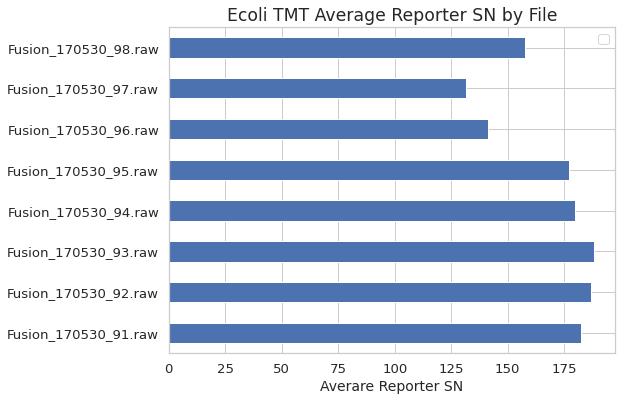

In [42]:
df3[
    ['Spectrum File', 'Average Reporter SN']
].groupby(
    ['Spectrum File']
).mean().plot.barh(figsize=(8,6))
plt.title(f'{PNUM} Average Reporter SN by File', fontsize='large')
plt.xlabel('Averare Reporter SN', fontsize=14)
plt.ylabel('')
plt.legend('')

Square root scale helps to compress the S/N range while preserving zero values.<br>
We are very interested to check how many quan spectra have S/N = 0,<br>
those would have been lost as a result of log-transformation.

Text(0.5, 0, 'Square Root of AVG Reporter SN')

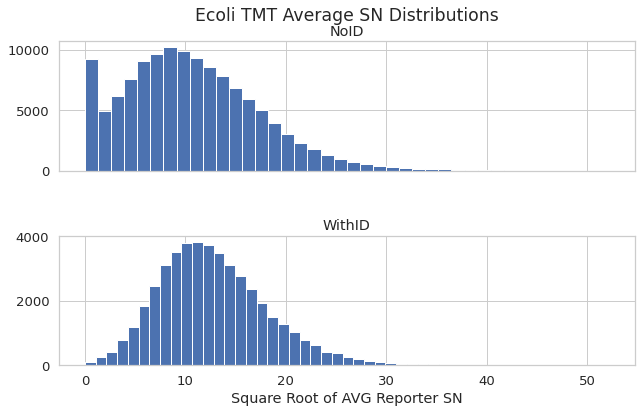

In [43]:
df3[
    ['Identified Peptide', 'Sqrt AVG Reporter SN']
].hist(
    by='Identified Peptide', bins=40, sharex=True,# sharey=True,# log=True,
    layout=(2,1), xrot=0, figsize=(10,6)
)
plt.suptitle(f'{PNUM} Average SN Distributions')
plt.xlabel('Square Root of AVG Reporter SN')

Use log10 S/N for hexbin plot, otherwise the zero values can saturate the color map.

Text(0, 0.5, 'Log10 AVG Reporter SN')

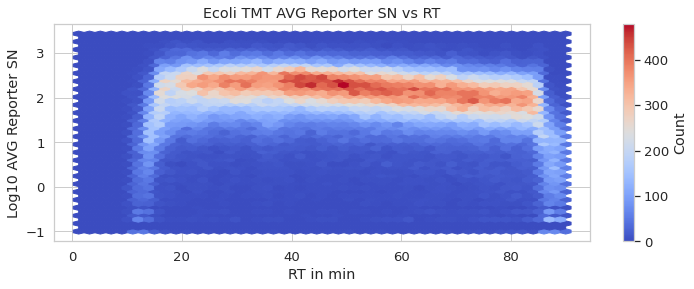

In [45]:
fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = (12, 4)
hb = ax.hexbin(
    x=df3['RT in min'], y=df3['Log10 AVG Reporter SN'],
    gridsize=int(maxRT/2),
    cmap='coolwarm'
)
cb = fig.colorbar(hb, ax=ax)
cb.set_label('Count')
plt.title(f'{PNUM} AVG Reporter SN vs RT')
plt.xlabel('RT in min')
plt.ylabel('Log10 AVG Reporter SN')

Spectra with S/N = 0 are excluded from the plot due to log-transformation, which puts emphasis on the quantified spectra.

Text(0.5, 1.0, 'Ecoli TMT AVG Reporter SN vs RT')

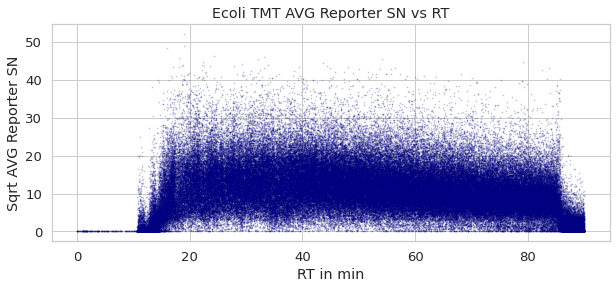

In [46]:
df3.plot.scatter(
    x='RT in min', y='Sqrt AVG Reporter SN',
    s=0.5,color='navy', alpha=0.2, figsize=(10, 4)
)
plt.title(f'{PNUM} AVG Reporter SN vs RT')

Weak spectra in the dead volume and at the very end are to be expected.<br>
Are the week spectra (AVG SN < 5) in our data set mostly concentrated at the beggining and at the end? 

Text(0.5, 0, 'RT (min)')

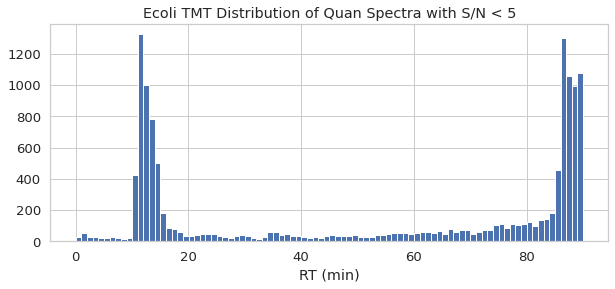

In [47]:
df3[
    df3['Average Reporter SN'] < 5
]['RT in min'].hist(
    bins=maxRT, figsize=(10, 4)
)
plt.title(f'{PNUM} Distribution of Quan Spectra with S/N < 5')
plt.xlabel('RT (min)')

Text(0, 0.5, 'Log10 AVG Reporter SN')

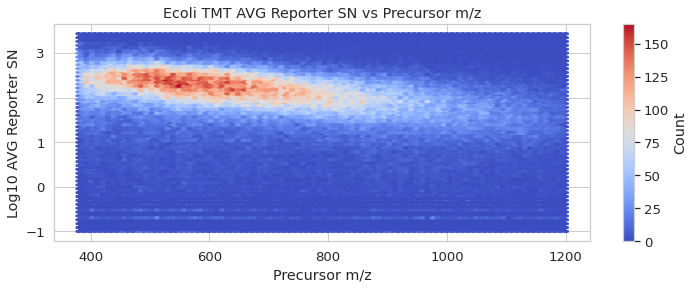

In [48]:
fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = (12, 4)
hb = ax.hexbin(
    x=df3['Precursor mz in Da'], y=df3['Log10 AVG Reporter SN'],
    gridsize=maxRT, cmap='coolwarm'
)
cb = fig.colorbar(hb, ax=ax)
cb.set_label('Count')
plt.title(f'{PNUM} AVG Reporter SN vs Precursor m/z')
plt.xlabel('Precursor m/z')
plt.ylabel('Log10 AVG Reporter SN')

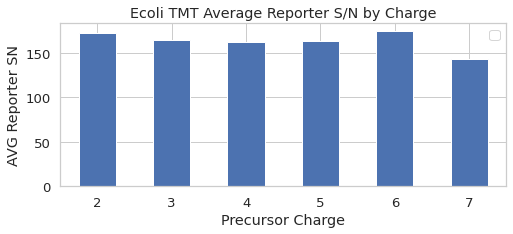

In [49]:
df3[
    ['Precursor Charge', 'Average Reporter SN']
].groupby(
    ['Precursor Charge']
).mean().plot.bar(figsize=(8,3), rot=0)
plt.title(f'{PNUM} Average Reporter S/N by Charge')
plt.ylabel('AVG Reporter SN')
plt.legend('')

<h3>File PSMs</h3>

In [50]:
df4 = pd.read_csv(
    os.getcwd() + [ n for n in proteomicTxtFiles if 'PSMs' in n ][0],
    sep='\t'
)
print(df4.shape)
print(df4.columns)
df4.head(3)

(45687, 50)
Index(['PSMs Workflow ID', 'PSMs Peptide ID', 'Checked', 'Confidence',
       'Identifying Node', 'PSM Ambiguity', 'Annotated Sequence',
       'Modifications', 'Number of Proteins', 'Master Protein Accessions',
       'Protein Accessions', 'Number of Missed Cleavages', 'Charge',
       'Delta Score', 'Delta Cn', 'Rank', 'Search Engine Rank', 'mz in Da',
       'MHplus in Da', 'Theo MHplus in Da', 'Delta M in ppm', 'Delta mz in Da',
       'Activation Type', 'MS Order', 'Isolation Interference in Percent',
       'SPS Mass Matches in Percent', 'Average Reporter SN',
       'Ion Inject Time in ms', 'RT in min', 'First Scan', 'Spectrum File',
       'File ID', 'Abundance 126', 'Abundance 127N', 'Abundance 127C',
       'Abundance 128N', 'Abundance 128C', 'Abundance 129N', 'Abundance 129C',
       'Abundance 130N', 'Abundance 130C', 'Abundance 131', 'Quan Info',
       'Ions Score', 'Number of Protein Groups', 'Identity Strict',
       'Identity Relaxed', 'Expectation Value', 

,PSMs Workflow ID,PSMs Peptide ID,Checked,Confidence,Identifying Node,PSM Ambiguity,Annotated Sequence,Modifications,Number of Proteins,Master Protein Accessions,...,Abundance 130C,Abundance 131,Quan Info,Ions Score,Number of Protein Groups,Identity Strict,Identity Relaxed,Expectation Value,Percolator q-Value,Percolator PEP
0,-107,8,False,High,Mascot (A5),Unambiguous,[R].lATAAAN.[-],N-Term(TMT6plex),1,P33015,...,969.6,115.4,NaN,31,1,13.0,13.0,0.000145,0.000414,0.001910
1,-107,9,False,High,Mascot (A5),Unambiguous,[R].aGPAGIR.[T],N-Term(TMT6plex),1,P05791,...,147.7,138.4,NaN,33,1,13.0,13.0,0.000101,0.002074,0.042430
2,-107,12,False,High,Mascot (A5),Unambiguous,[R].aGAGLVR.[V],N-Term(TMT6plex),1,P31806,...,169.0,131.6,NaN,41,1,13.0,13.0,0.000015,0.000403,0.001656


Text(0, 0.5, 'Mascot Ion Score')

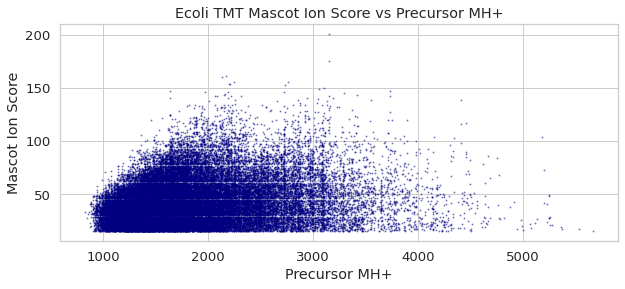

In [51]:
df4.plot.scatter(
    x='MHplus in Da', y='Ions Score', s=1,color='navy', alpha=0.4, figsize=(10, 4)
)
plt.title(f'{PNUM} Mascot Ion Score vs Precursor MH+')
plt.xlabel('Precursor MH+')
plt.ylabel('Mascot Ion Score')

SPS match is a measure of quantitative interference for MS3 TMT workflows calculated by Proteome Discoverer.<br>
It takes the number of the MS2 fragments that have been selected and isolated for MS3,<br>
and calculates the percentage of those MS2 that match to the annotated MS2 fragments of the main identified peptide.<br>
Thus, high SPS match % should mean that the interference from unknown peptides is low.

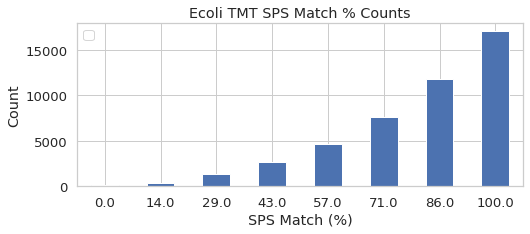

In [52]:
df4[
    ['SPS Mass Matches in Percent', 'Isolation Interference in Percent']
].groupby(
    ['SPS Mass Matches in Percent']
).count().plot.bar(figsize=(8,3), rot=0)
plt.title(f'{PNUM} SPS Match % Counts')
plt.ylabel('Count')
plt.xlabel('SPS Match (%)')
plt.legend('')

Proteome Dsicoverer calculates the isolation interference for precursors as well.<br>
This is the percentage of signals within the precursor isolation window that do not belong to the main precursor isotopic envelope.

Text(0.5, 0, 'Isolation Interference in %')

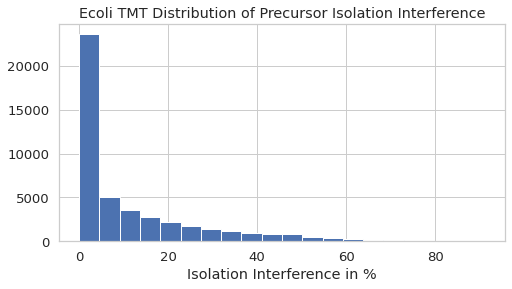

In [53]:
df4['Isolation Interference in Percent'].hist(
    bins = 20, figsize=(8, 4)
)
plt.title(f'{PNUM} Distribution of Precursor Isolation Interference')
plt.xlabel('Isolation Interference in %')

The SPS match and precursor interference values are sort of linked, but not very much:

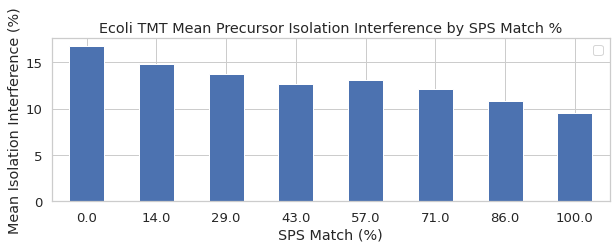

In [54]:
df4[
    ['SPS Mass Matches in Percent', 'Isolation Interference in Percent']
].groupby(
    ['SPS Mass Matches in Percent']
).mean().plot.bar(figsize=(10,3), rot=0)
plt.title(f'{PNUM} Mean Precursor Isolation Interference by SPS Match %')
plt.ylabel('Mean Isolation Interference (%)')
plt.xlabel('SPS Match (%)')
plt.legend('')

Inspect the precursor mass error

Text(0, 0.5, 'Mass error, ppm')

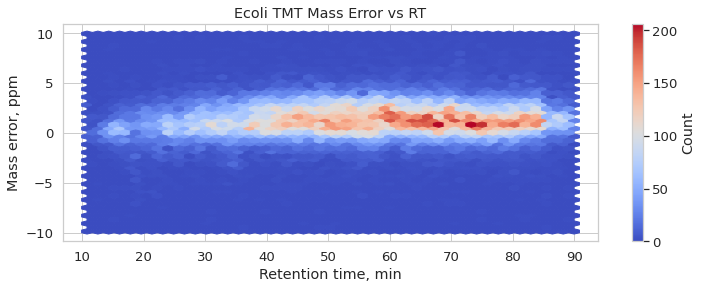

In [55]:
fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = (12, 4)
hb = ax.hexbin(
    x=df4['RT in min'], y=df4['Delta M in ppm'],
    gridsize = int( maxRT/2 ),
    cmap = 'coolwarm'
)
cb = fig.colorbar(hb, ax=ax)
cb.set_label('Count')
plt.title(f'{PNUM} Mass Error vs RT')
plt.xlabel('Retention time, min')
plt.ylabel('Mass error, ppm')

Text(0.5, 1.0, 'Ecoli TMT Mass Error vs RT')

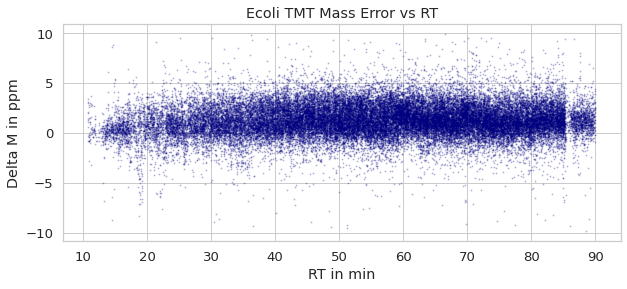

In [56]:
df4.plot.scatter(
    x='RT in min', y='Delta M in ppm',
    s=1,color='navy', alpha=0.2, figsize=(10, 4)
)
plt.title(f'{PNUM} Mass Error vs RT')

<h3>File PeptideGroups</h3>

In [12]:
df5 = pd.read_csv(
        os.getcwd() + [ n for n in proteomicTxtFiles if 'PeptideGroups' in n ][0],
    sep='\t'
)
df5 = rename_ratios4(df5)
print(df5.shape)
print(df5.columns)
df5.head(3)

(25794, 49)
Index(['Peptide Groups Peptide Group ID', 'Checked', 'Confidence',
       'Annotated Sequence', 'Modifications', 'Qvality PEP', 'Qvality q-value',
       'Number of Protein Groups', 'Number of Proteins', 'Number of PSMs',
       'Accession', 'Positions in Master Proteins',
       'Modifications in Master Proteins', 'Number of Missed Cleavages',
       'Theo MHplus in Da', 'S02/S01', 'S03/S01', 'S04/S01', 'S05/S01',
       'S06/S01', 'S07/S01', 'S08/S01', 'S09/S01', 'S10/S01', 'S01', 'S02',
       'S03', 'S04', 'S05', 'S06', 'S07', 'S08', 'S09', 'S10', 'Quan Info',
       'Found in Sample in S1 F1 126 Sample S01',
       'Found in Sample in S2 F1 127N Sample S02',
       'Found in Sample in S3 F1 127C Sample S03',
       'Found in Sample in S4 F1 128N Sample S04',
       'Found in Sample in S5 F1 128C Sample S05',
       'Found in Sample in S6 F1 129N Sample S06',
       'Found in Sample in S7 F1 129C Sample S07',
       'Found in Sample in S8 F1 130N Sample S08',
       'Fo

,Peptide Groups Peptide Group ID,Checked,Confidence,Annotated Sequence,Modifications,Qvality PEP,Qvality q-value,Number of Protein Groups,Number of Proteins,Number of PSMs,...,Found in Sample in S5 F1 128C Sample S05,Found in Sample in S6 F1 129N Sample S06,Found in Sample in S7 F1 129C Sample S07,Found in Sample in S8 F1 130N Sample S08,Found in Sample in S9 F1 130C Sample S09,Found in Sample in S10 F1 131 Sample S10,Confidence by Search Engine Mascot,Percolator q-Value by Search Engine Mascot,Percolator PEP by Search Engine Mascot,Ions Score by Search Engine Mascot
0,1,False,High,[R].AAAAEIAVK.[T],1xTMT6plex [K9]; 1xTMT6plex [N-Term],0.000219,0.000121,1,1,1,...,High,High,High,High,High,High,High,0.000347,0.000506,66
1,3,False,High,[R].AAAAQQAGLK.[L],1xTMT6plex [K10]; 1xTMT6plex [N-Term],0.000094,0.000076,1,1,1,...,High,High,High,High,High,High,High,0.000297,0.000374,66
2,4,False,High,[R].AAADEWDER.[-],1xTMT6plex [N-Term],0.000327,0.000121,1,1,4,...,High,High,High,High,High,High,High,0.000351,0.000606,46


In [13]:
df5['Number of PSMs'].unique()

array([ 1,  4,  2, 10, 12,  6,  8,  5,  3,  7, 14, 13,  9, 18, 11, 45, 15,
       16, 33, 59, 55, 20, 31, 24, 30, 19, 23, 32, 17, 44, 25, 54, 28, 26,
       22, 69, 61, 35, 66, 50, 21, 27, 43])

Find columns that contain abundance ratios

In [14]:
df5.iloc[:, 15:24].dropna(axis='rows')

,S02/S01,S03/S01,S04/S01,S05/S01,S06/S01,S07/S01,S08/S01,S09/S01,S10/S01
0,1.396,2.063,0.987,1.946,2.244,2.897,1.987,2.277,0.737
1,0.964,1.327,0.983,1.054,1.401,1.271,1.486,1.328,0.824
2,1.045,1.604,0.985,1.514,1.474,2.200,1.688,1.724,1.245
3,1.076,2.016,1.003,1.182,1.290,1.415,1.456,1.329,0.964
4,0.647,0.549,1.003,0.662,0.454,0.582,0.592,0.700,0.918
...,...,...,...,...,...,...,...,...,...
25789,1.455,1.248,0.882,1.748,0.952,1.859,2.188,2.893,1.154
25790,1.237,0.806,1.046,1.092,0.951,1.294,1.412,1.433,1.092
25791,0.992,0.269,0.941,0.127,0.163,0.417,0.381,0.766,1.094
25792,0.875,0.325,0.970,0.082,0.166,0.309,0.353,0.639,1.005


In [15]:
df5.columns[15:24]

Index(['S02/S01', 'S03/S01', 'S04/S01', 'S05/S01', 'S06/S01', 'S07/S01',
       'S08/S01', 'S09/S01', 'S10/S01'],
      dtype='object')

How many peptides have missing quantitative values?

In [16]:
peptidesMVFraction = 1 - df5.iloc[:, 15:24].dropna(axis='rows').shape[0] / df5.iloc[:, 15:24].shape[0]
peptidesMVFraction = peptidesMVFraction * 100
f'Peptides with missing quan values: {peptidesMVFraction:.1f}%'

'Peptides with missing quan values: 3.3%'

Multi-batch data sets may have very high prevalence of missing values.<br>
Single-batch isobaric labeling with too many missing values may raise suspicion.<br>
One could review the processing parameters, as an example

Let's look at the variability of the peptide ratios within each protein.<br>
In the ideal case, we expect peptides within a protein to have very similar intensity profiles.

           S02/S01  S03/S01  S04/S01  S05/S01  S06/S01  S07/S01  S08/S01  \
Accession                                                                  
A5A614       23.47    17.30    37.32    48.93    33.49    11.15     4.44   
P00350       20.85    10.86     9.40     9.01    14.43     8.13     9.50   
P00363       15.07     7.46     5.23    35.38    23.18    13.40    11.40   

           S09/S01  S10/S01  
Accession                    
A5A614       21.35    91.60  
P00350       10.59    11.04  
P00363       16.33    27.60  


Text(0.5, 0, 'Log10 Peptide Variability (%)')

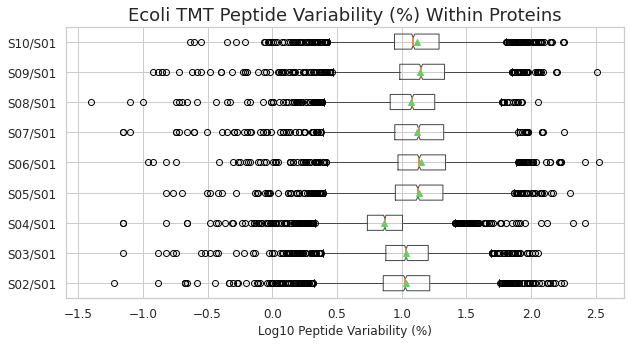

In [17]:
dfPeptVar = variability_groupby(
    df5[ (['Accession', ] + list(df5.columns[15:24]) ) ].dropna(axis='rows'),
    ratio_columns = list( df5.columns[15:24] )
)
print(dfPeptVar.head(3))
np.log10(
    dfPeptVar.replace(0, np.nan)
).boxplot(
    figsize=(10,5),
    notch=True, showmeans=True, vert=False,
    medianprops= dict(linewidth=2), fontsize=12
)
plt.title(f'{PNUM} Peptide Variability (%) Within Proteins', fontsize=18)
plt.xlabel('Log10 Peptide Variability (%)', fontsize=12)
#plt.xticks(rotation=45, horizontalalignment='right')

In [18]:
dfPeptVar.describe()

,S02/S01,S03/S01,S04/S01,S05/S01,S06/S01,S07/S01,S08/S01,S09/S01,S10/S01
count,2261.000000,2261.000000,2259.000000,2261.000000,2261.000000,2262.000000,2261.000000,2262.000000,2259.000000
mean,14.598333,13.585498,9.130040,17.818815,18.712517,17.171521,14.635887,18.330071,18.069296
std,14.779242,10.754610,10.256851,15.904476,18.530752,13.750915,10.279753,16.628493,18.096294
min,0.060000,0.070000,0.070000,0.150000,0.110000,0.070000,0.040000,0.120000,0.230000
25%,7.200000,7.540000,5.430000,8.930000,9.360000,8.840000,8.150000,9.660000,8.795000
50%,10.660000,10.810000,7.410000,13.340000,13.670000,13.520000,12.050000,14.110000,12.270000
75%,16.470000,16.040000,10.150000,20.820000,21.820000,21.110000,18.000000,21.430000,19.440000
max,178.310000,112.200000,260.220000,198.260000,333.160000,179.380000,113.340000,323.690000,178.190000


Pretty low within-protein-variabilities for peptide ratios, with mean values between 9 and 19%

We could look at the correlations between the abundance ratios on peptide level.<br>
Should remain careful while interpreting the correlation:<br>
as I have described in [my recent blog post](https://towardsdatascience.com/correlation-in-isobaric-labeling-proteomics-926045214f96), the correlation coefficients are highly dependent on the way in which the data has been scaled.

Text(0.5, 0.98, 'Ecoli TMT Pearson Correlations on Peptide Level')

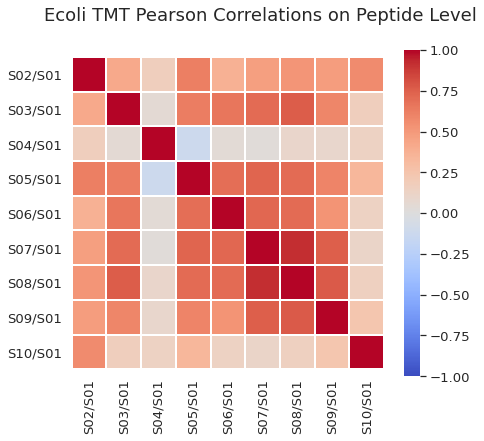

In [19]:
f = plt.figure(figsize=(7,6))
sns.heatmap(
    np.log2(
        df5.iloc[:, 15:24].dropna(axis='rows')
    ).corr(method='pearson').round(2),
    square=True, cmap='coolwarm', vmin=-1, vmax=1,
    annot=False, cbar=True, linewidth=2, linecolor='white'
)
plt.suptitle(f'{PNUM} Pearson Correlations on Peptide Level',fontsize=18)

A more nuanced depiction with the pairplots

Text(0.5, 0.98, 'Ecoli TMT Pair Plots on Peptide Level')

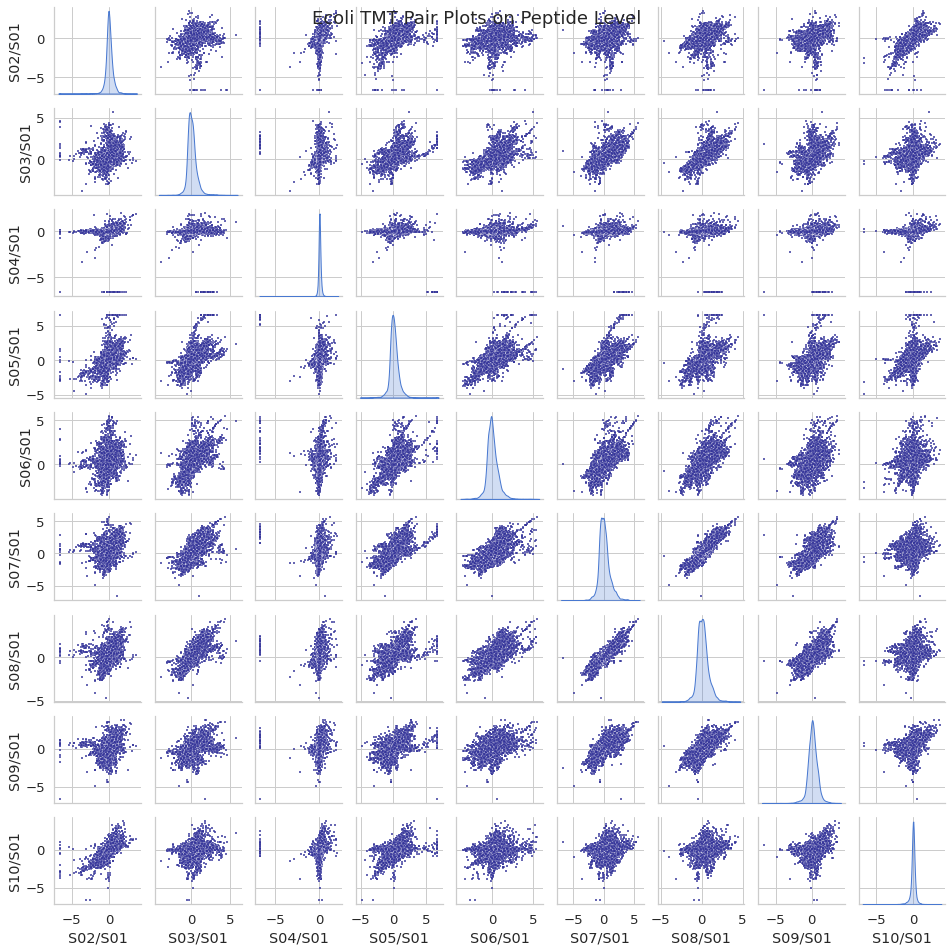

In [20]:
sns.pairplot(
    np.log2(
        df5.iloc[:, 15:24].dropna(axis='rows')
    ),
    vars=df5.iloc[:, 15:24].columns,
    diag_kind='kde', kind='scatter', markers=',', height = 1.5,
    plot_kws={'s': 8,  'alpha':0.7, 'color': 'navy'}
)
plt.suptitle(f'{PNUM} Pair Plots on Peptide Level', fontsize=18)

Let's check the efficiency of the enzymatic digestion

Text(0.5, 0.98, 'Ecoli TMT Peptides by Missed Cleavages')

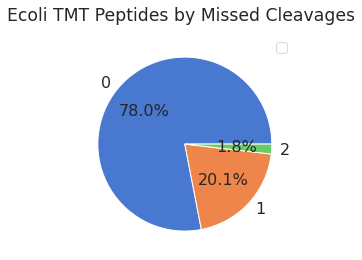

In [21]:
fig1, ax1 = plt.subplots()
df5[
    ['Number of Missed Cleavages', 'Confidence']
].groupby(
    ['Number of Missed Cleavages']
).count().plot(
    kind='pie', ax=ax1,
    y='Confidence', figsize=(4,4),
    autopct='%1.1f%%',fontsize=16
)
fig1.set_facecolor("white")
ax1.set_ylabel('')
plt.legend('')
plt.suptitle(f'{PNUM} Peptides by Missed Cleavages')

We could also check the cysteine containing peptides. Cysteine residues are usually modified via reduction and alkylation, and it's good to check that the derivatization has been done properly. If not, the abundances of cysteine-containing peptides may be very low in the samples that have experienced issues.

Let's mark the derivatized cysteine residues in a separate column.

In [28]:
df5['Cys_Peptide'] = [
    'Yes' if '[C' in x else 'No' for x in df5['Modifications']
]

In [31]:
df5[ df5['Cys_Peptide'] == 'Yes' ].head(3)

,Peptide Groups Peptide Group ID,Checked,Confidence,Annotated Sequence,Modifications,Qvality PEP,Qvality q-value,Number of Protein Groups,Number of Proteins,Number of PSMs,...,Found in Sample in S6 F1 129N Sample S06,Found in Sample in S7 F1 129C Sample S07,Found in Sample in S8 F1 130N Sample S08,Found in Sample in S9 F1 130C Sample S09,Found in Sample in S10 F1 131 Sample S10,Confidence by Search Engine Mascot,Percolator q-Value by Search Engine Mascot,Percolator PEP by Search Engine Mascot,Ions Score by Search Engine Mascot,Cys_Peptide
13,17,False,High,[K].AAAEVGAPFIEIHTGCYADAK.[T],1xMethylthio [C16]; 1xTMT6plex [K21]; 1xTMT6pl...,7.588440e-09,0.000020,1,1,2,...,High,High,High,High,High,High,0.000060,0.000007,55,Yes
22,27,False,High,[K].AAAICAER.[G],1xMethylthio [C5]; 1xTMT6plex [N-Term],5.206060e-04,0.000194,1,1,3,...,High,High,High,High,High,High,0.000367,0.000788,51,Yes
34,41,False,High,[R].AAATGEALSLVCVDEHK.[L],1xMethylthio [C12]; 1xTMT6plex [K17]; 1xTMT6pl...,7.022640e-10,0.000020,1,1,1,...,High,High,High,High,High,High,0.000060,0.000002,71,Yes


In [35]:
np.log2(df5[ df5['Cys_Peptide'] == 'Yes' ].iloc[:, 15:24].dropna(axis='rows'))

,S02/S01,S03/S01,S04/S01,S05/S01,S06/S01,S07/S01,S08/S01,S09/S01,S10/S01
13,0.063503,0.028569,0.012926,0.079975,0.196607,0.316146,0.438293,0.367371,0.008630
22,-0.386468,-0.816037,-0.004335,-0.727380,-0.432455,-1.347399,-1.080088,0.086784,-0.045431
34,-0.194295,-0.508403,0.063503,-0.744197,-1.067939,-0.905088,-0.899695,-0.330973,0.025738
66,-0.161653,-0.327348,-0.309359,-0.921390,-0.878321,-1.894322,-0.715486,-0.242977,0.276199
70,0.380729,0.146655,0.077243,0.480265,0.516015,0.220330,0.361768,0.470927,0.048236
...,...,...,...,...,...,...,...,...,...
25691,-0.960160,-0.685014,-0.026205,-1.098506,-0.504305,-0.249822,-0.066427,0.374066,-0.030619
25696,0.064883,-0.145605,0.214125,0.347099,0.119024,-0.148801,-0.134477,0.181421,-0.095420
25723,0.008630,-0.407364,0.158337,-0.312939,-0.403542,-0.603841,-0.378944,-0.107803,0.490570
25724,0.025738,-0.275786,0.056584,-0.118727,-0.242977,-0.630394,-0.239566,0.008630,0.336855


Text(0.5, 0.98, 'Ecoli TMT Modified Cys Peptide Log2 Relative Ints')

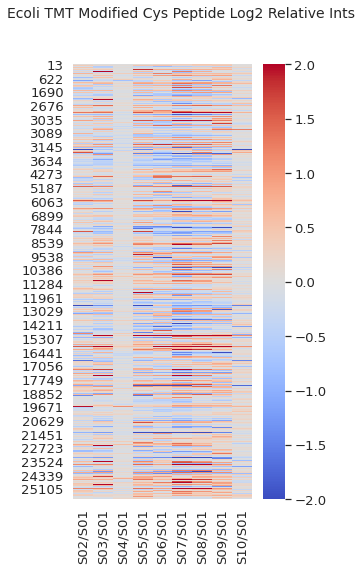

In [41]:
f = plt.figure(figsize=(4,8))
sns.heatmap(
    np.log2(
        df5[
            df5['Cys_Peptide'] == 'Yes'
        ].iloc[
            :, 15:24
        ].dropna(axis='rows')
    ),
    square=False, cmap='coolwarm', vmin=-2, vmax=2,
    annot=False, cbar=True
)
plt.suptitle(f'{PNUM} Modified Cys Peptide Log2 Relative Ints',fontsize=14)

/home/trainee/.local/lib/python3.8/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Text(0.5, 0.98, 'Ecoli TMT Modified Cys Peptide Log2 Relative Ints')

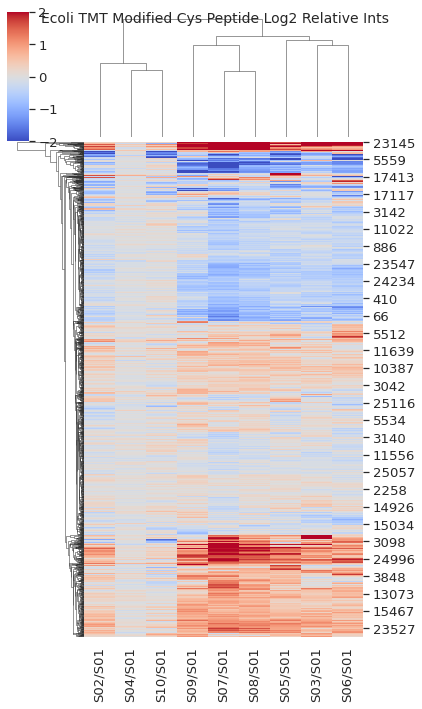

In [46]:
sns.clustermap(
    np.log2(
        df5[
            df5['Cys_Peptide'] == 'Yes'
        ].iloc[
            :, 15:24
        ].dropna(axis='rows')
    ),
    figsize=(6,10),
    cmap='coolwarm', vmin=-2, vmax=2
)
plt.suptitle(f'{PNUM} Modified Cys Peptide Log2 Relative Ints',fontsize=14)

We could compare it to the peptides without cysteins to get a sense of a baseline.

/home/trainee/.local/lib/python3.8/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Text(0.5, 0.98, 'Ecoli TMT Peptide without Cys Log2 Relative Ints')

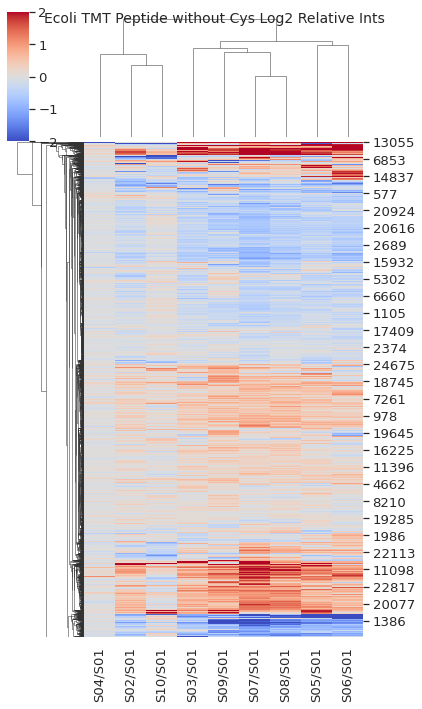

In [47]:
sns.clustermap(
    np.log2(
        df5[
            df5['Cys_Peptide'] == 'No'
        ].iloc[
            :, 15:24
        ].dropna(axis='rows')
    ),
    figsize=(6,10),
    cmap='coolwarm', vmin=-2, vmax=2
)
plt.suptitle(f'{PNUM} Peptide without Cys Log2 Relative Ints',fontsize=14)

<h3>File Proteins</h3>

In [67]:
df6 = pd.read_csv(
    os.getcwd() + [ n for n in proteomicTxtFiles if 'Proteins' in n ][0],
    sep='\t'
)
df6 = rename_ratios4(df6)
df6['Gene'] = [ get_gene_name(x) for x in df6['Description'] ]
print(df6.shape)
print(df6.columns)
df6.head(3)

(2704, 49)
Index(['Proteins Unique Sequence ID', 'Checked',
       'Protein FDR Confidence Combined', 'Master', 'Accession', 'Description',
       'Exp q-value Combined', 'Sum PEP Score', 'Coverage in Percent',
       'Number of Peptides', 'Number of PSMs', 'Number of Unique Peptides',
       'Number of AAs', 'MW in kDa', 'calc pI', 'Score Mascot Mascot',
       'Number of Peptides by Search Engine Mascot', 'S02/S01', 'S03/S01',
       'S04/S01', 'S05/S01', 'S06/S01', 'S07/S01', 'S08/S01', 'S09/S01',
       'S10/S01', 'S01', 'S02', 'S03', 'S04', 'S05', 'S06', 'S07', 'S08',
       'S09', 'S10', 'Found in Sample in S1 F1 126 Sample S01',
       'Found in Sample in S2 F1 127N Sample S02',
       'Found in Sample in S3 F1 127C Sample S03',
       'Found in Sample in S4 F1 128N Sample S04',
       'Found in Sample in S5 F1 128C Sample S05',
       'Found in Sample in S6 F1 129N Sample S06',
       'Found in Sample in S7 F1 129C Sample S07',
       'Found in Sample in S8 F1 130N Sample S08',

,Proteins Unique Sequence ID,Checked,Protein FDR Confidence Combined,Master,Accession,Description,Exp q-value Combined,Sum PEP Score,Coverage in Percent,Number of Peptides,...,Found in Sample in S4 F1 128N Sample S04,Found in Sample in S5 F1 128C Sample S05,Found in Sample in S6 F1 129N Sample S06,Found in Sample in S7 F1 129C Sample S07,Found in Sample in S8 F1 130N Sample S08,Found in Sample in S9 F1 130C Sample S09,Found in Sample in S10 F1 131 Sample S10,Number of Protein Groups,Modifications,Gene
0,-9221854764723615317,False,High,IsMasterProtein,P0AE52,Peroxiredoxin Bcp OS=Escherichia coli (strain ...,0.0,37.669,56,9,...,High,High,High,High,High,High,High,1,Methylthio [C46; C51],bcp
1,-9211239412768113427,False,High,IsMasterProtein,P22333,Adenosine deaminase OS=Escherichia coli (strai...,0.0,32.732,26,8,...,High,High,High,High,High,High,High,1,Methylthio [C76],add
2,-9209034104888575193,False,High,IsMasterProtein,P0A901,Outer membrane lipoprotein Blc OS=Escherichia ...,0.0,18.184,31,6,...,High,High,High,High,High,High,High,1,NaN,blc


In [68]:
df6['Master'].unique()

array(['IsMasterProtein', 'None', 'IsMasterProteinRejected',
       'IsMasterProteinCandidate'], dtype=object)

In [69]:
df6['Protein FDR Confidence Combined'].unique()

array(['High', 'Medium'], dtype=object)

I marked the common proteomic contaminants with the prefix "cont_" in the Uniprot accession while constructing the sequence database.<br>
Now we could look at the number and relative intensitiy profile of the contaminants.

In [70]:
df6cont = df6[ df6['Accession'].str.contains('cont_') ].copy()
df6cont = df6cont[
    ( df6cont['Master'] == 'IsMasterProtein' )
]
df6cont.shape

(13, 49)

In [71]:
df6cont.set_index('Gene').iloc[:, 17:26].head(3)

,S02/S01,S03/S01,S04/S01,S05/S01,S06/S01,S07/S01,S08/S01,S09/S01,S10/S01
Gene,,,,,,,,,
KRT2,0.725,0.655,0.789,0.714,1.213,0.699,0.552,0.898,0.741
KRT14,0.859,0.509,0.713,1.147,2.242,1.193,0.605,1.170,1.274
KRT10,0.642,0.764,0.673,0.740,1.394,0.719,0.579,0.886,0.795


Text(0.5, 0.98, 'Ecoli TMT Log2 Relative Intensities of Proteomic Contaminants')

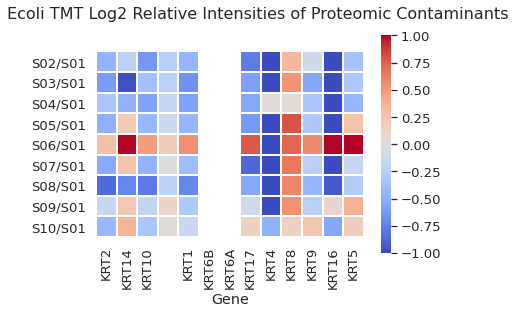

In [72]:
f = plt.figure(figsize=(6,4))
sns.heatmap(
    np.log2(
        df6cont.set_index('Gene').iloc[:, 17:26].T
    ),
    square=True, cmap='coolwarm', vmin=-1, vmax=1,
    annot=False, cbar=True, linewidth=2, linecolor='white'
)
plt.suptitle(f'{PNUM} Log2 Relative Intensities of Proteomic Contaminants',fontsize=16)

Excessive amounts of contamination in some of the samples might influence the results negatively,<br>
especially when samples have low abundance.

Let's proceed with non-contaminant proteins

In [73]:
df6 = df6[ ~df6['Accession'].str.contains('cont_') ]
df6 = df6[
    ( df6['Master'] == 'IsMasterProtein' )
]
df6.set_index('Accession', inplace=True)
print(df6.shape)
df6.head(3)

(2636, 48)


,Proteins Unique Sequence ID,Checked,Protein FDR Confidence Combined,Master,Description,Exp q-value Combined,Sum PEP Score,Coverage in Percent,Number of Peptides,Number of PSMs,...,Found in Sample in S4 F1 128N Sample S04,Found in Sample in S5 F1 128C Sample S05,Found in Sample in S6 F1 129N Sample S06,Found in Sample in S7 F1 129C Sample S07,Found in Sample in S8 F1 130N Sample S08,Found in Sample in S9 F1 130C Sample S09,Found in Sample in S10 F1 131 Sample S10,Number of Protein Groups,Modifications,Gene
Accession,,,,,,,,,,,,,,,,,,,,,
P0AE52,-9221854764723615317,False,High,IsMasterProtein,Peroxiredoxin Bcp OS=Escherichia coli (strain ...,0.0,37.669,56,9,16,...,High,High,High,High,High,High,High,1,Methylthio [C46; C51],bcp
P22333,-9211239412768113427,False,High,IsMasterProtein,Adenosine deaminase OS=Escherichia coli (strai...,0.0,32.732,26,8,13,...,High,High,High,High,High,High,High,1,Methylthio [C76],add
P0A901,-9209034104888575193,False,High,IsMasterProtein,Outer membrane lipoprotein Blc OS=Escherichia ...,0.0,18.184,31,6,7,...,High,High,High,High,High,High,High,1,NaN,blc


In [74]:
print( [ (i, c) for i, c in enumerate(df6.columns) ] )

[(0, 'Proteins Unique Sequence ID'), (1, 'Checked'), (2, 'Protein FDR Confidence Combined'), (3, 'Master'), (4, 'Description'), (5, 'Exp q-value Combined'), (6, 'Sum PEP Score'), (7, 'Coverage in Percent'), (8, 'Number of Peptides'), (9, 'Number of PSMs'), (10, 'Number of Unique Peptides'), (11, 'Number of AAs'), (12, 'MW in kDa'), (13, 'calc pI'), (14, 'Score Mascot Mascot'), (15, 'Number of Peptides by Search Engine Mascot'), (16, 'S02/S01'), (17, 'S03/S01'), (18, 'S04/S01'), (19, 'S05/S01'), (20, 'S06/S01'), (21, 'S07/S01'), (22, 'S08/S01'), (23, 'S09/S01'), (24, 'S10/S01'), (25, 'S01'), (26, 'S02'), (27, 'S03'), (28, 'S04'), (29, 'S05'), (30, 'S06'), (31, 'S07'), (32, 'S08'), (33, 'S09'), (34, 'S10'), (35, 'Found in Sample in S1 F1 126 Sample S01'), (36, 'Found in Sample in S2 F1 127N Sample S02'), (37, 'Found in Sample in S3 F1 127C Sample S03'), (38, 'Found in Sample in S4 F1 128N Sample S04'), (39, 'Found in Sample in S5 F1 128C Sample S05'), (40, 'Found in Sample in S6 F1 129N 

In [75]:
np.log2( df6.iloc[:, 16:25].dropna(axis='rows') ).head(3)

,S02/S01,S03/S01,S04/S01,S05/S01,S06/S01,S07/S01,S08/S01,S09/S01,S10/S01
Accession,,,,,,,,,
P0AE52,0.283329,0.295135,-0.032094,0.580145,0.375178,0.643394,0.539035,0.659011,0.028569
P22333,0.216610,0.432959,0.025738,0.348232,0.212881,0.779890,0.336855,2.290129,-0.128156
P0A901,0.396159,0.832688,0.314986,1.102322,1.061431,1.695103,1.370722,0.773996,0.101650


Variance explained by components:
[0.44827784 0.15229853 0.14338961 0.08088777 0.07034337]
Figure width set to 8 and height to 5.2


<Figure size 864x288 with 0 Axes>

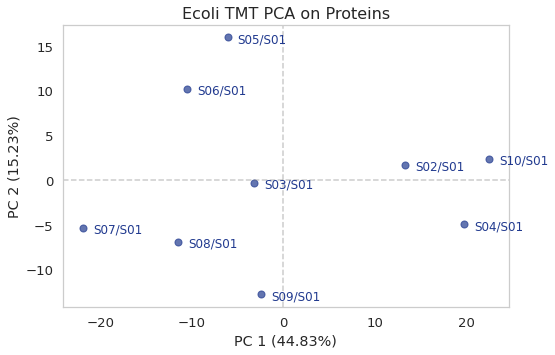

In [76]:
pca_coords, loadings = pca_on_columns(
    np.log2(
        df6.iloc[:, 16:25].dropna(axis='rows')
    ),
    f'{PNUM} PCA on Proteins', figWidth = 8
)

Variance explained by components:
[0.44827784 0.15229853 0.14338961 0.08088777 0.07034337]
Figure width set to 8 and height to 6.5


<Figure size 864x288 with 0 Axes>

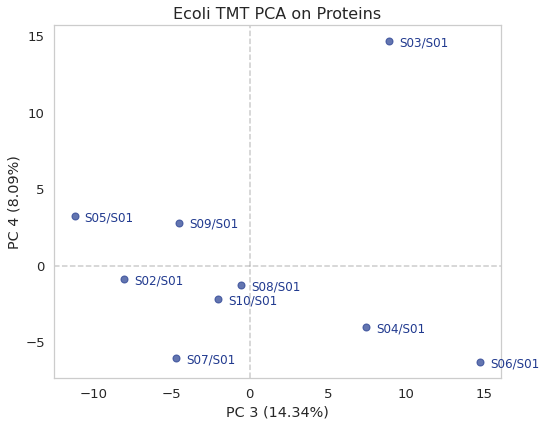

In [77]:
pca_coords, loadings = pca_on_columns(
    np.log2(
        df6.iloc[:, 16:25].dropna(axis='rows')
    ),
    f'{PNUM} PCA on Proteins', figWidth = 8,
    compToPlot = (2,3)
)

Text(0.5, 0.98, 'Ecoli TMT Pearson Correlations on Protein Level')

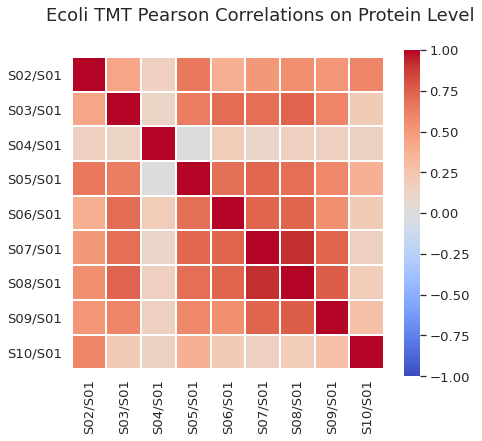

In [78]:
f = plt.figure(figsize=(7,6))
sns.heatmap(
    np.log2(
        df6.iloc[:, 16:25].dropna(axis='rows')
    ).corr(method='pearson').round(2),
    square=True, cmap='coolwarm', vmin=-1, vmax=1,
    annot=False, cbar=True, linewidth=2, linecolor='white'
)
plt.suptitle(f'{PNUM} Pearson Correlations on Protein Level',fontsize=18)

Text(0.5, 0.98, 'Ecoli TMT Pair Plots on Protein Level')

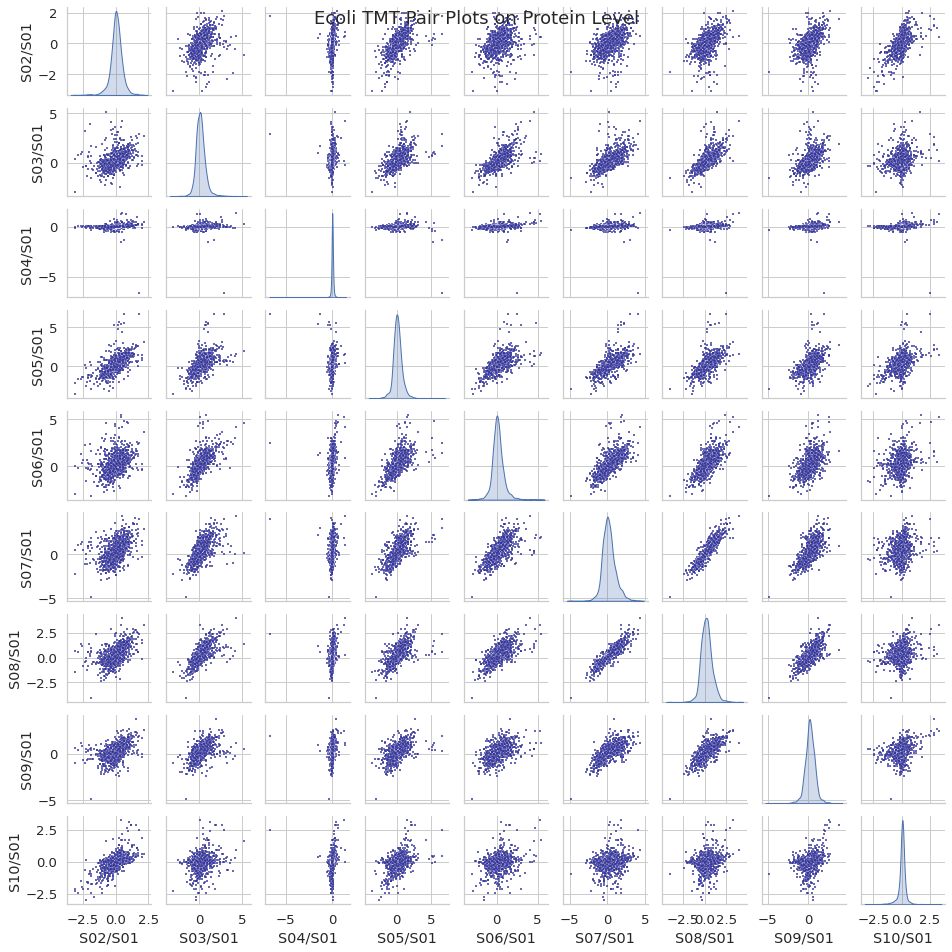

In [79]:
sns.pairplot(
    np.log2(
        df6.iloc[:, 16:25].dropna(axis='rows')
    ),
    vars=df6.iloc[:, 16:25].columns,
    diag_kind='kde', kind='scatter', markers=',', height = 1.5,
    plot_kws={'s': 8,  'alpha':0.7, 'color': 'navy'}
)
plt.suptitle(f'{PNUM} Pair Plots on Protein Level', fontsize=18)